Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import seaborn as sns
import os

--------
Define functions

In [2]:
# This function classifies a timeseries' disturbance date, 
# based on whether or not it is a cleared stand or a thinned stand.
# It translates the disturbance map raster code into an integer value 
# for year of disturbance.

# Add a year-disturbed column to dataset
def StandAge(pixVal):

    if 14 <= pixVal <= 41:

        return pixVal + 1970

    elif 64 <= pixVal <= 91:

        return pixVal + 1920

    else:
        return -9999
    
# This also uses the disturbance map. It classifies a timeseries based on whether or 
# not it was cleared completely, or whether it was just a thinning disturbance. 

# enter a pixel value
def dMapClasses(pixVal):
    # if it is in the range of forests...
    if 14 <= pixVal <= 91:
        # if it is in the range of clears...
        if 14 <= pixVal <= 41: 
            return "Clear"
        # else if in the range of nonclears...
        elif 64 <= pixVal <= 91:
            return "Thin"
    else:
        return "Other"

---
Add dataframes. 

1. Leaf Area Index Acquisitions 
2. Disturbance Map Pixel Values (1984-2011)

In [3]:
# Change the directory
os.chdir("/Users/wyatt/Desktop/Thesis_Final_Push/Threshold9_County_Polygon_Data")

# Load leaf area index timeseries data
lai = pd.read_csv("/Users/wyatt/Downloads/HUC10_LAI_Timeseries_HucCut.csv")

# Load information from disturbance date raster
dist = pd.read_csv("/Users/wyatt/Downloads/HUC10_Disturbance_Map.csv")

In [4]:
# Merge in LAI data, an inner join
mrgd = lai.merge(right = dist, \
                               how = "inner", \
                               on = ".geo")

In [5]:
# apply disturbance classes to the map
mrgd['dist_classes'] = mrgd.mean_y.apply(dMapClasses)

# create a stand age field
mrgd['dist_year'] = mrgd.mean_y.apply(StandAge)

# Acquisition date
mrgd['date'] = mrgd['imageId'].apply(lambda x: pd.to_datetime(x.split("_")[-1]))

---
Estimate age in years

*This is not a perfect age, but rather one that takes into account that we do not know the exact date of the original stand clearing disturbance. This is a lumping operation which loses precision but nevertheless generates a useful column.

In [6]:
# Make sure that all disturbance years are real
mrgd = mrgd[mrgd.dist_year > 0]

# Here, create the date filter for getting just february
mrgd["month"] = mrgd.date.apply(lambda x: x.month)
mrgd = mrgd[mrgd.month == 2]

In [7]:
# Create a year column
mrgd["year"] = mrgd.date.apply(lambda x: x.year)

# estimate a disturbance date from disturbance year string. First day of year for all
mrgd['est_dist_date'] = mrgd.dist_year.apply(\
             lambda x: pd.to_datetime(str(x)[:4] + "-01-01"))

# Make an estimated age in year/season terms by subtracting the year of disturbance from the acquisition clumps...
mrgd['age'] = mrgd['year'] - mrgd['dist_year']

Now we will refine the dataset into the columns that we really want: 

1. LAI 
2. ID
3. Age
4. Date
5. Age (years)
6. Lat and Long (not this until we figure out issues)

In [8]:
# include date, age, year/winter thing, year/age/winter thing, the lai, and the ID 
df = mrgd[['date', 'age', 'mean_x', '.geo']]

# make LAI an understandable col
df['LAI'] = df['mean_x']

# This is the default second disturbance
df["D2"] = pd.to_datetime("2014-01-01")

# Re-arrange the columns
df = df[[".geo", "LAI", "date", "D2", "age"]]

# Re-name the columns
df.columns = ["ID", "LAI", "DATE", "D2", "AGE"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Examine the data, and export.

In [9]:
# Cut out data before and on the year of stand clearing disturbance
df = df[df["AGE"] >= 1]

# Realistic LAI value
df = df[df["LAI"] >= 0]
df = df[df["LAI"] < 10]

# Acquisition before clearcut
df = df[df["DATE"] < df["D2"]]

# Make sure that there are no duplicate values
df = df.drop_duplicates()

---
---
Visualizations

In [10]:
# Accept dataframe, age column, estimated year age winter clump column, lai, date, second disturbance, how to aggr.
def lai_by_age(df, year_age_col, val_col, date_col, d2_col, AGG): 
    
    # Age above zero
    df = df[df[year_age_col] >= 0]
    
    # Realistic LAI value
    df = df[df[val_col] >= 0]
    df = df[df[val_col] < 10]
    
    # Acquisition before clearcut
    df = df[df[date_col] < df[d2_col]]
    
    # Create x values corresponding to number of winters
    x = np.array(list(set(df[year_age_col])))
    
    # create lists to hold mean and std bounds
    mean_list = []
    std_list = []
    
    # Iterate over number of winters
    for year in x:
        # Create dataframe for this year
        sub = df[df[year_age_col] == year]
        
        # Decide on which yearly aggregation, then group by ID to get a winterly composite.
        if AGG == "MIN": 
            sub = sub.groupby("ID").min().reset_index()
        elif AGG == "MED": 
            sub = sub.groupby("ID").median().reset_index()
        elif AGG == "MAX":
            sub = sub.groupby("ID").max().reset_index()
        elif AGG == "None":
            sub = sub
        
        # List LAI
        lai_values = list(sub[val_col])
        
        # take mean
        mean_lai = np.mean(lai_values)
        
        # take standard deviation
        std_lai = np.std(lai_values)
        
        # append lists
        mean_list.append(mean_lai)
        std_list.append(std_lai)
    
    
    # create figure
    fig, ax = plt.subplots(figsize = (12, 8))
    
    # create axes
    ax = plt.axes()
    
    # label axes
    plt.xlabel("Years Since Stand Clearing Disturbance", size = 18)
    plt.ylabel("LAI", size = 18)
    
    # Presentation stuff, visualization
    plt.rcParams['savefig.pad_inches'] = 0
    plt.rcParams.update({'font.size': 14})
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    # Put error bars on the chart
    ax.errorbar(x, mean_list, yerr=std_list, fmt='o',\
                color = "black", capsize = 3)

    
    # set ticks
    plt.xticks(np.arange(1, len(x) + 1), [int(i) for i in x])

In [11]:
# Accept dataframe, year of choice, age/winter/year, date, lai, second disturbance, what to aggregate by...
def given_year_histogram(df, yr, year_age_col, date_col, val_col, d2_col, AGG):
    
    ## SUBSET DF ###################################
    
    # subset the dataframe for the given year
    sub = df[df[year_age_col] == yr]
    
    # subset the dataframe for values that are past the potential second harvest date
    sub = sub[sub[date_col] < sub[d2_col]]
    
    # subset the dataframe for only LAI values that are realistic
    sub = sub[sub[val_col] >= 0]
    sub = sub[sub[val_col] < 10]
    #################################
        
    ## AGGREGATE DF ####################################
    
    if AGG == "MIN": 
        sub = sub.groupby("ID").min().reset_index()
    elif AGG == "MED": 
        sub = sub.groupby("ID").median().reset_index()
    elif AGG == "MAX": 
        sub = sub.groupby("ID").max().reset_index()
    elif AGG == "None":
        sub = sub
    #####################################################
    
    
    ### PLOT HISTOGRAM ##############################
    
    # Create axes object
    fig, ax = plt.subplots(figsize = (12, 8))
    ax = plt.axes()
    
    # Make axis labels and viz parameters
    plt.xlabel("LAI", size = 18)
    plt.ylabel("Count", size = 18)
    plt.rcParams['savefig.pad_inches'] = 0
    plt.rcParams.update({'font.size': 14})
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Plot the data
    plt.hist(np.array(sub[val_col]), bins = 30, facecolor='none', edgecolor='black')
    
    # Annotate N
    plt.annotate(s = "n = " + str(len(np.array(sub[val_col]))),\
            xy = (0.8, 0.85),\
            xycoords = "figure fraction")
    ####################################################################################

In [12]:
def plot_n(df, year_age_col, val_col, date_col, d2_col, AGG):
    
    #### 1. Subset DF ###
    
    # Age above zero
    df = df[df[year_age_col] >= 0]
    
    # Realistic LAI value
    df = df[df[val_col] >= 0]
    df = df[df[val_col] < 10]

    # Acquisition before clearcut
    df = df[df[date_col] < df[d2_col]]
    
    ###      ###
    
    # Create x values corresponding to number of winters
    x = np.array(list(set(df[year_age_col])))
    y = []
    
    # Iterate over number of winters
    for year in x:
        # Create dataframe for this year
        sub = df[df[year_age_col] == year]
        
        if AGG == "MIN": 
            sub = sub.groupby("ID").min().reset_index()
        elif AGG == "MED": 
            sub = sub.groupby("ID").median().reset_index()
        elif AGG == "MAX": 
            sub = sub.groupby("ID").max().reset_index()
        elif AGG == "None":
            sub = sub
        
        # List LAI
        lai_values = list(sub[val_col])
        
        # List number of values
        num_values = len(lai_values)
        
        # put in list
        y.append(num_values)
        
    # create figure
    fig, ax = plt.subplots(figsize = (12, 8))
    
    # create axes
    ax = plt.axes()
    
    # label axes
    plt.xlabel("Years Since Stand Clearing Disturbance", size = 18)
    plt.ylabel("Count", size = 18)
    
    # Presentation stuff, visualization
    plt.rcParams['savefig.pad_inches'] = 0
    plt.rcParams.update({'font.size': 14})
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    ax.plot(x, y, "-o", color = "black")
    plt.xticks(np.arange(0, len(x)), [int(i) for i in x])

In [33]:
def maximum_lai_histogram2(df, id_col, date_col, age_col,\
                           val_col, agg, age_threshold):
    
    maxlist = []
    yearlist = []
    
    # set up id numbers
    idlist = list(set(df[id_col]))
    
    for i in idlist:
        # pick an ID
        sub = df[df[id_col] == i]
        
        # subset between two disturbances
#         d1 = sub[dist_col1].iloc[0]
        
        d2 = sub.D2.iloc[0]
        
        sub = sub[sub[age_col] > 0]
#         sub = sub[sub[date_col] < d2]
        
        # subset for realistic LAI
        sub = sub[sub[val_col] < 10]
        sub = sub[sub[val_col] >= 0]
        
        # subset by how old the stand becomes
        if sub.AGE.max() >= age_threshold:
            
        
            # group by age in years, and take median value
            if agg == "MED":
                sub = sub.groupby(age_col).median().reset_index()
            elif agg == "MIN":
                sub = sub.groupby(age_col).min().reset_index()
            elif agg == "MAX": 
                sub = sub.groupby(age_col).max().reset_index()

            # subset by number of points

            if len(sub[val_col]) > 7:

                # take maximum
                maxlist.append(sub.iloc[\
                                       int(sub[[val_col]].idxmax())\
                                       ][val_col])

                # take year of maximum
                yearlist.append(sub.iloc[\
                                        int(sub[[val_col]].idxmax())\
                                        ][age_col])

                # take lat of maximum
#                 latlist.append(sub.iloc[\
#                                         int(sub[[val_col]].idxmax())\
#                                         ][lat_col])

                # take lon of maximum
#                 lonlist.append(sub.iloc[\
#                                         int(sub[[val_col]].idxmax())\
#                                         ][lon_col])
            else:
                maxlist.append(np.nan)
                yearlist.append(np.nan)
#                 latlist.append(np.nan)
#                 lonlist.append(np.nan)
        else:
            continue

    return maxlist, yearlist

In [45]:
def tenyrLAI_hist(df, id_col, date_col, age_col,\
                           val_col, agg, age_threshold):
    yr10LAI = []
    
    idlist = list(set(df[id_col]))
    
    for i in idlist:
        sub = df[df[id_col] == i]
        
        d2 = sub.D2.iloc[0]
        
        sub = sub[sub[age_col] > 0]
        sub = sub[sub[date_col] < d2]
        
        sub = sub[sub[val_col] < 10]
        sub = sub[sub[val_col] >= 0]
        
        if sub.AGE.max() >= age_threshold:
            
            
            if agg == "MED":
                sub = sub.groupby(age_col).median().reset_index()
            elif agg == "MIN":
                sub = sub.groupby(age_col).min().reset_index()
            elif agg == "MAX": 
                sub = sub.groupby(age_col).max().reset_index()
                
            if len(sub[val_col]) > 7:
                
                if 10 in list(sub[age_col]):
            
                    laiage10 = sub[sub[age_col == 10]][age_col]
                    yr10LAI.append(laiage10)
                    
    plt.hist(yr10LAI)

In [15]:
# Accepts dataframe, col to hist, and title for fig
def paper_hist(df, col, title):
    
    # Create axes
    fig, ax = plt.subplots(1, 1, figsize = (12, 8))
    ax = plt.axes()
    
    # Viz params
    plt.xlabel(title, size = 18)
    plt.ylabel("Count", size = 18)
    plt.rcParams['savefig.pad_inches'] = 0
    plt.rcParams.update({'font.size': 14})
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Plot data and annotate N
    plt.hist(np.array(df[col]), bins = 30, facecolor='none', edgecolor='black')


In [16]:
def stand_ages(df, id_col, yr_age_col, val_col, date_col, d2_col):
    
    df = df[df[yr_age_col] >= 0]
    
    # Realistic LAI value
    df = df[df[val_col] >= 0]
    df = df[df[val_col] < 10]
    
    # Acquisition before clearcut
    df = df[df[date_col] < df[d2_col]]
    
    sub = df[[id_col, yr_age_col]].groupby(id_col).max()
    
    rowDict = {}
    
    for i in range(0, 28):
        rowDict[i] = len(sub[sub[yr_age_col] == i])
    
    for i in range(28, 32):
        rowDict[i] = rowDict[i] = len(sub[sub[yr_age_col] == 28]) / 4
    
    
#     # Add three rows for 2015, 2016, and 2017
#     four_bottom = sub[sub[yr_age_col == 28]]
#     size_four = len(four_bottom)/4
    
#     y = np.array(sub[yr_age_col]) 
    
#     y = y.append(size_four)
    
    
    
#     # make that plot
#     fig, ax = plt.subplots(1, 1, figsize = (12, 8))
#     ax = plt.axes()
    
#     plt.xlabel("Year of Clearcut", size = 18)
#     plt.ylabel("Count", size = 18)
#     plt.rcParams['savefig.pad_inches'] = 0
#     plt.rcParams.update({'font.size': 14})
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
# #     plt.hist(np.array(sub[yr_age_col]), bins = 30, facecolor = "none", edgecolor = "black")
# #     plt.hist(rowDict, bins = 30, facecolor = "none", edgecolor = "black")
#     plt.bar(rowDict.keys(), rowDict.values(), facecolor = "none", edgecolor = "black")
# #     x = np.array(sub[yr_age_col])
#     plt.xticks(np.arange(0, len(rowDict.keys())), list(rowDict.keys()))
    
    return rowDict
    

---
---

---
---

Results:

1. Overall, LAI peaks once around 12 years of age, and then again has a strong peak at 29 years of age, or the end of growing season.
2. Min LAI has a peak of around 2.
3. Rotation ages (according to the maps) somewhat linearly taper off

Chart of LAI by Age

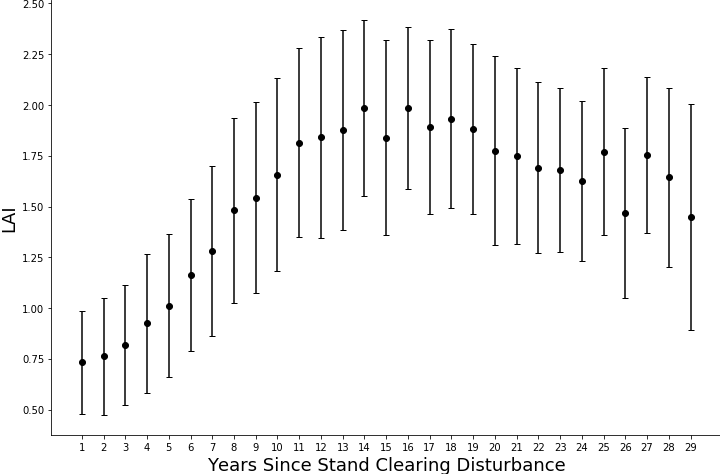

In [17]:
lai_by_age(df = df, year_age_col = "AGE",\
           val_col = "LAI",\
           date_col = "DATE", d2_col = "D2", AGG = "MAX")

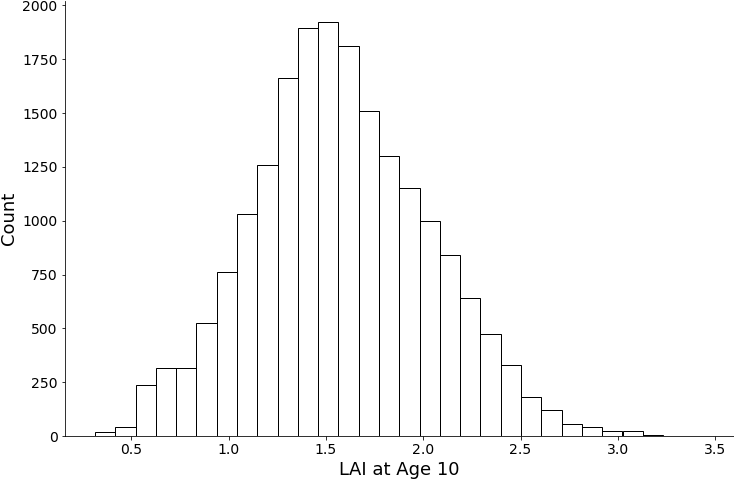

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax = plt.axes()

plt.ylabel("Count", size = 18)
plt.xlabel("LAI at Age 10", size = 18)

plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams.update({'font.size': 14})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.hist(np.array(df[df.AGE == 10].LAI), bins = 30, facecolor='none', edgecolor='black');



Plot Number of Data Points


Create histogram of all LAI values within a specific stand age

---
---

Create Maximum LAI Dataset

In [34]:
year_threshold = 20
# M, Y, LAT, LON = maximum_lai_histogram(df, "ID", "DATE", "YR_AGE", "AGE", "LAI",\
#                                        "LAT", "LON", "MIN", year_threshold)

M, Y = maximum_lai_histogram2(df = df, id_col = "ID", date_col = "DATE",\
                       age_col = "AGE", \
                       val_col = "LAI", agg = "MIN", age_threshold = year_threshold)

maxDF = pd.DataFrame()
maxDF["MAX"] = M
maxDF["YEAR"] = Y

maxDF = maxDF.dropna()

In [ ]:
np.mean(maxDF.MAX)

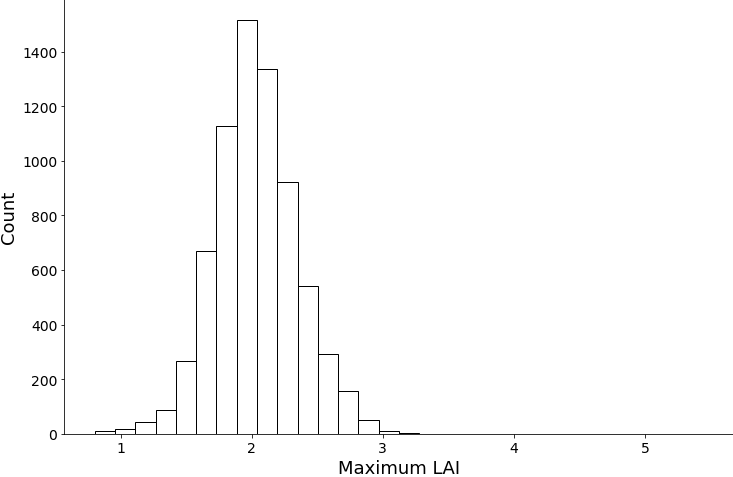

In [47]:
paper_hist(maxDF, "MAX", "Maximum LAI")

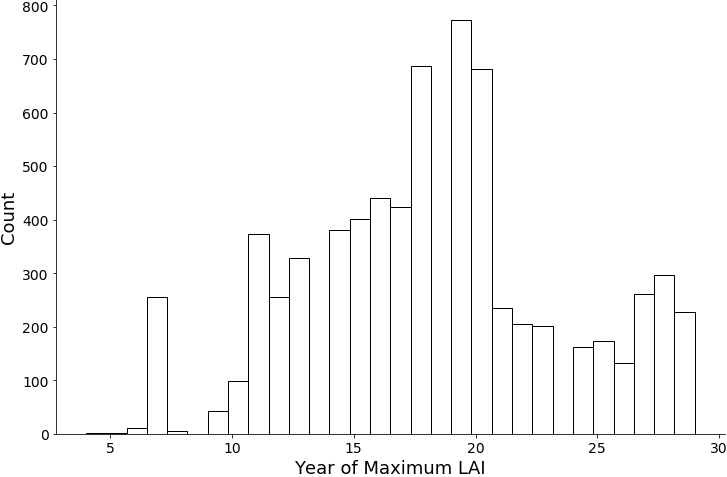

In [48]:
paper_hist(maxDF, "YEAR", "Year of Maximum LAI")